In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

data = pd.read_csv('inningScore.csv') 
print(data.head())

print(data.columns)

  Team  1  2  3  4  5  6  7  8  9  ...  10  11  12  13  14  15  16  17  18  19
0  STL  0  0  0  0  0  0  0  0  1  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
1  PIT  0  2  0  0  0  1  0  1  -  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2  TOR  2  0  0  1  0  0  0  2  0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
3   TB  0  0  1  0  0  0  0  0  2  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
4  NYM  0  0  0  0  0  0  0  3  0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

[5 rows x 24 columns]
Index(['Team', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'R', 'H', 'E',
       'Game', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')


In [10]:
To_which_inning = 5

def Sum_to_n_inning(To_which_inning):  
    # sum from 1st inning to 5th inning for every row
    col_list = [str(i) for i in range(1, To_which_inning+1)]

    # Convert columns to numeric type
    data[col_list] = data[col_list].apply(pd.to_numeric, errors='coerce')   

    data['InningSum'] = data[col_list].sum(axis=1, numeric_only=True)
    sum_data = data[['Team', 'Game', 'InningSum']].copy()

    # print(sum_data.head(10))

    # For every Game, calculate the abs difference between the two teams 
    # One Game print out one row
    sum_data.loc[:, 'SumDiff'] = sum_data.groupby('Game')['InningSum'].transform(lambda x: abs(x.diff()))

    # only print distinct Game
    diff_data = sum_data[['Game', 'SumDiff']]
    diff_data = diff_data.dropna()
    # print(diff_data.head())

    plt.title(f'SumDiff to the end of Inning {To_which_inning}')
    sns.histplot(diff_data['SumDiff'], bins=20, kde=True)

## Plot the run difference to the end of inning 1-8

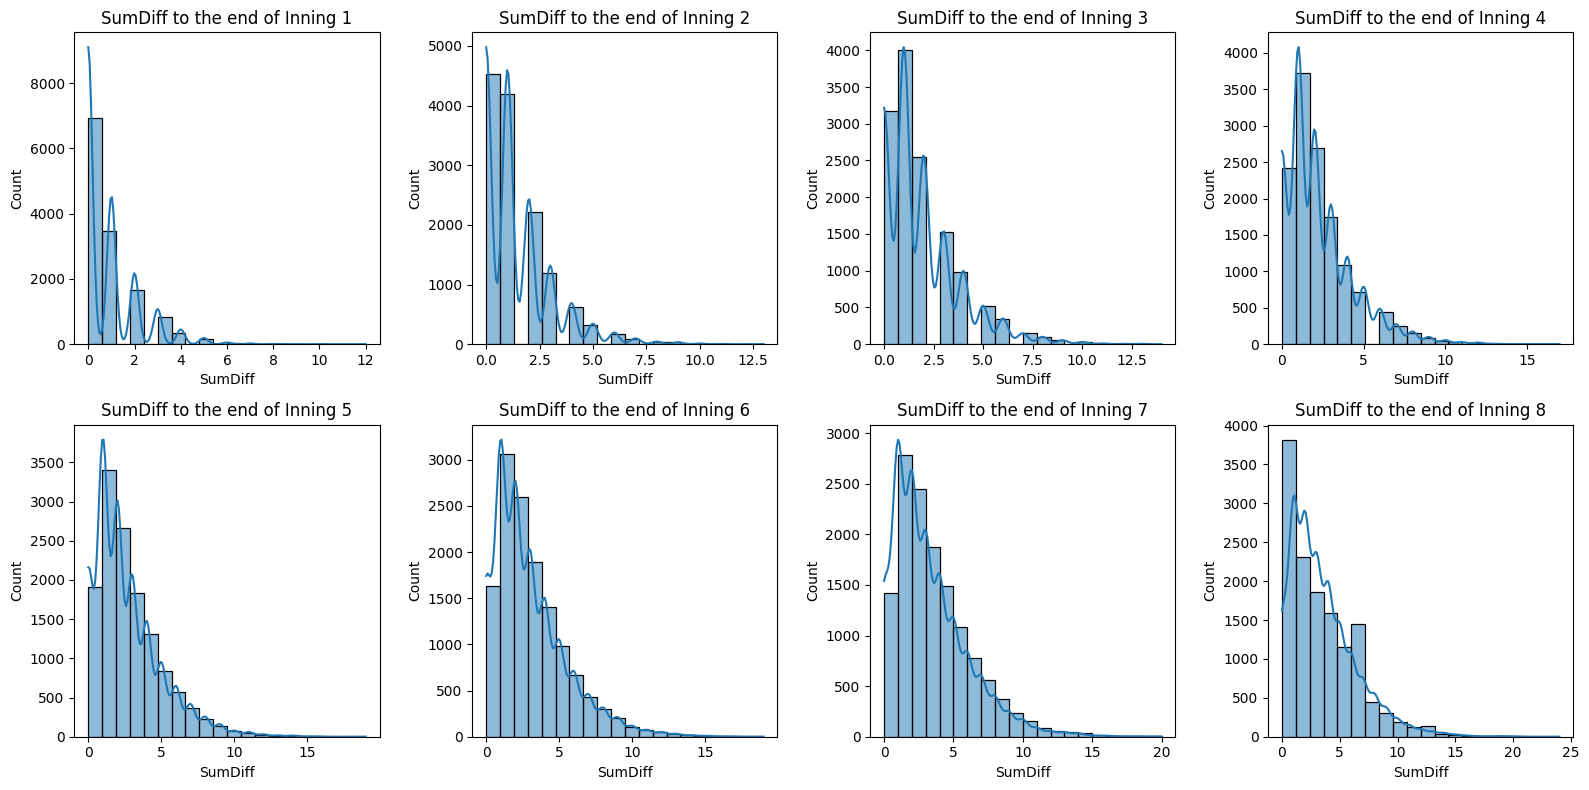

In [11]:
# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns

for i, ax in enumerate(axs.flat, start=1):
    plt.subplot(2, 4, i)  # Set current subplot
    Sum_to_n_inning(i)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Run difference at the End of the Game

ScoreDiff
1.0     3689
2.0     2397
3.0     1941
4.0     1568
5.0     1152
6.0      816
7.0      621
8.0      410
9.0      290
10.0     193
11.0     123
12.0      76
13.0      65
14.0      40
15.0      24
16.0      13
0.0        8
17.0       7
18.0       7
19.0       4
21.0       3
20.0       3
Name: count, dtype: int64


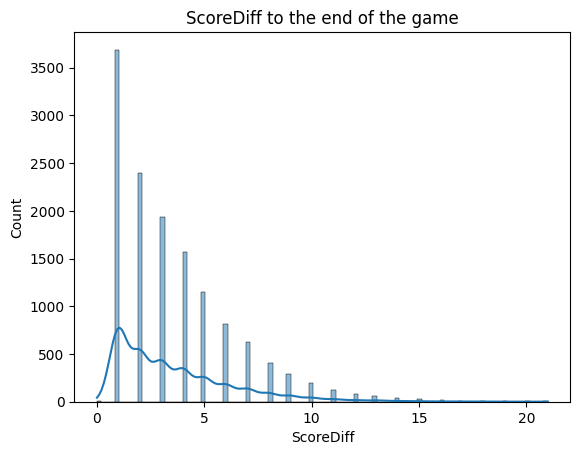

In [12]:
# sum elements in all_inning if it is not NaN
all_inning = [str(i) for i in range(1, 20)]
# print(all_inning)

data[all_inning] = data[all_inning].replace({np.nan: 0, '-': 0})

# Convert columns to numeric type
data[all_inning] = data[all_inning].apply(pd.to_numeric, errors='coerce')

data["final_score"] = data[all_inning].sum(axis=1, numeric_only=True)

# calculate the difference between the two teams per game
# data['ScoreDiff'] = data.groupby('Game')['final_score'].transform(lambda x: x.diff())
data['ScoreDiff'] = data.groupby('Game')['final_score'].transform(lambda x: abs(x.diff()))

# print(data.head())

ScoreDiff_data = data[['Game', 'ScoreDiff']].dropna()

print(ScoreDiff_data['ScoreDiff'].value_counts())

plt.title('ScoreDiff to the end of the game')
sns.histplot(ScoreDiff_data['ScoreDiff'], bins=100, kde=True)

plt.show()

In [13]:
'''
Preform normality test
'''
from scipy import stats

data = ScoreDiff_data['ScoreDiff']
stat, p_val = stats.kstest(data, 'norm', [data.mean(), data.std()])
print(f'mean: {data.mean()}; variance: {data.var()}')
if p_val > 0.05:
    print('normally distributed')
else:
    print('not normally distributed')

mean: 3.5749442379182157; variance: 7.674396327472558
not normally distributed


In [14]:
'''
Try test for Poisson or Exponential (with abs(x.diff())).
Since the mean and variance of our data is not close, it is unlikely a Poisson distribution.
Same reason for the exponential distribution.

@TODO Try below
'''

scale = 1 / data.mean()
stat, p_val = stats.kstest(data, stats.expon.cdf, [0, scale])
p_val

0.0

estimated param: (0.00011400679955283176, 0, 4.522615649759954)


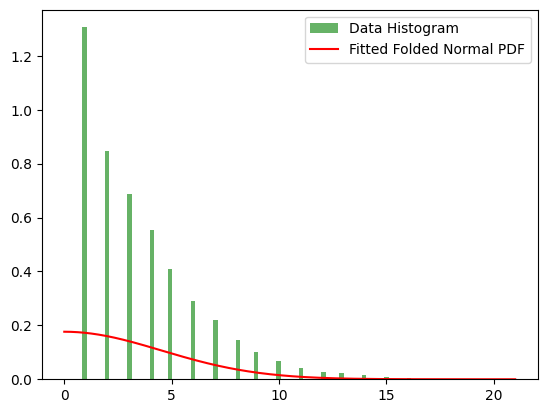

Kolmogorov-Smirnov Test: D=0.17439918601076682, p-value=0.0
Reject the null hypothesis: The data does not follow the folded normal distribution.


In [16]:
"""
Test whether our data fits "folded normal distribution".

It turns out that the resuklt is NO.
"""

# Plot histogram of the data
plt.hist(data, bins=100, density=True, alpha=0.6, color='g', label='Data Histogram')

# Fit the data to a folded normal distribution
param = stats.foldnorm.fit(data, floc=0)

print(f'estimated param: {param}')

# Get the PDF of the fitted folded normal distribution
x = np.linspace(0, max(data), 1000)
pdf_fitted = stats.foldnorm.pdf(x, *param)
plt.plot(x, pdf_fitted, 'r-', label='Fitted Folded Normal PDF')

plt.legend()
plt.show()

# Kolmogorov-Smirnov Test
D, p_value_ks = stats.kstest(data, 'foldnorm', args=param)
print(f'Kolmogorov-Smirnov Test: D={D}, p-value={p_value_ks}')

# Interpretation
alpha = 0.05  # Common significance level
if p_value_ks > alpha:
    print("Fail to reject the null hypothesis: The data follows the folded normal distribution.")
else:
    print("Reject the null hypothesis: The data does not follow the folded normal distribution.")

# if ad_statistic < critical_values[2]:  # Use the 5% significance level critical value
#     print("Fail to reject the null hypothesis: The data follows the folded normal distribution.")
# else:
#     print("Reject the null hypothesis: The data does not follow the folded normal distribution.")